In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [3]:
df_train = pd.read_csv('PM_train.csv')
df_test = pd.read_csv('PM_test.csv')
df_truth = pd.read_csv('PM_truth.csv')

In [4]:
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [5]:
df_truth.head()

,id,cycle
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91


In [6]:
# Рассчитаем значение показателя оставшегося ресурса времени (Remaining Useful Life, RUL)
for i in range(1, 101):
    max_rul = df_train[df_train['id'] == i]['cycle'].max()
    df_train.loc[df_train['id'] == i, 'RUL'] = df_train[df_train['id'] == i]['cycle'].apply(lambda x: max_rul - x)

In [7]:
# Создадим новые метки (label) в тренировочном наборе данных df_train, которые будут использоваться для задачи классификации
# на основе RUL
# Задание пороговых значений
w0, w1 = 15, 30

# Метка label1 будет содержать значения 1 или 0 в зависимости от того, меньше или равно ли значение RUL пороговому значению w1
df_train['label1'] = np.where(df_train['RUL'] <= w1, 1, 0)

# Метка label2 классифицировать данные в зависимости от оставшегося времени работы
df_train['label2'] = np.where(df_train['RUL'] > w1,
                              0,
                              np.where((df_train['RUL'] <= w1) & (df_train['RUL'] > w0),
                                      1, 2))

In [8]:
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191.0,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190.0,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189.0,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188.0,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187.0,0,0


In [9]:
# нормализуем выбранные столбцы, сохраняя исходные данные для указанных столбцов, которые не должны подвергаться нормализации

def normalize_data(df, col_not_to_norm):
    columns_to_normalize = df.columns.difference(col_not_to_norm) 
    
    # Separate the columns
    df_to_normalize = df[columns_to_normalize]
    df_not_to_normalize = df[col_not_to_norm]
    
    # Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Fit and transform the data
    normalized_df = pd.DataFrame(scaler.fit_transform(df_to_normalize), columns=columns_to_normalize)

    return pd.concat([df_not_to_normalize, normalized_df], axis=1)

In [10]:
columns_not_to_normalize = ['id', 'cycle', 'RUL', 'label1', 'label2']
df_train = normalize_data(df_train, columns_not_to_normalize)
df_train.head()

,id,cycle,RUL,label1,label2,s1,s10,s11,s12,s13,...,s3,s4,s5,s6,s7,s8,s9,setting1,setting2,setting3
0,1,1,191.0,0,0,0.0,0.0,-0.266467,0.334262,-1.058890,...,-0.134255,-0.925936,-1.776357e-15,0.141683,1.121141,-0.516338,-0.862813,-0.315980,-1.372953,0.0
1,1,2,190.0,0,0,0.0,0.0,-0.191583,1.174899,-0.363646,...,0.211528,-0.643726,-1.776357e-15,0.141683,0.431930,-0.798093,-0.958818,0.872722,-1.031720,0.0
2,1,3,189.0,0,0,0.0,0.0,-1.015303,1.364721,-0.919841,...,-0.413166,-0.525953,-1.776357e-15,0.141683,1.008155,-0.234584,-0.557139,-1.961874,1.015677,0.0
3,1,4,188.0,0,0,0.0,0.0,-1.539489,1.961302,-0.224597,...,-1.261314,-0.784831,-1.776357e-15,0.141683,1.222827,0.188048,-0.713826,0.324090,-0.008022,0.0
4,1,5,187.0,0,0,0.0,0.0,-0.977861,1.052871,-0.780793,...,-1.251528,-0.301518,-1.776357e-15,0.141683,0.714393,-0.516338,-0.457059,-0.864611,-0.690488,0.0


In [12]:
# объединим данные из тестовой базы с данными реальных значений
df_test = pd.merge(df_test, df_truth.rename(columns={'cycle': 'RUL'}), on=['id'], how='left')

# добавляем столбец RUL
df_test['RUL'] = df_test['RUL'] - df_test['cycle']

# создаем метку label1 для тестовых данных
df_test['label1'] = np.where(df_test['RUL'] <= w1, 1, 0)

# создаем метку label2 для тестовых данных
df_test['label2'] = np.where(df_test['RUL'] > w1,
                              0,
                              np.where((df_test['RUL'] <= w1) & (df_test['RUL'] > w0),
                                      1, 2))

# нормализуем данные
df_test = normalize_data(df_test, columns_not_to_normalize)
df_test.head()

,id,cycle,RUL,label1,label2,s1,s10,s11,s12,s13,...,s3,s4,s5,s6,s7,s8,s9,setting1,setting2,setting3
0,1,1,111,0,0,0.0,-2.220446e-16,-1.103591,-0.049542,-0.720590,...,-0.561495,-0.975674,-1.776357e-15,0.17566,0.209138,-0.539078,-0.720312,1.049295,1.005927,0.0
1,1,2,110,0,0,0.0,-2.220446e-16,0.427727,0.736727,-0.193647,...,0.070116,-1.392836,-1.776357e-15,0.17566,1.603612,-1.061366,-0.348673,-1.220748,-1.034755,0.0
2,1,3,109,0,0,0.0,-2.220446e-16,0.427727,0.397202,-0.720590,...,-0.231698,-0.507676,-1.776357e-15,0.17566,0.517390,-0.364982,-0.126564,0.141278,0.325700,0.0
3,1,4,108,0,0,0.0,-2.220446e-16,-0.695239,-0.657113,-0.369295,...,-0.795350,0.251888,-1.776357e-15,0.17566,0.458675,-0.713174,-1.147041,1.911912,-0.014414,0.0
4,1,5,107,0,0,0.0,-2.220446e-16,-0.542108,0.718857,-0.720590,...,-0.181729,-0.420954,-1.776357e-15,0.17566,0.590783,-1.061366,-1.211750,0.640688,-0.014414,0.0


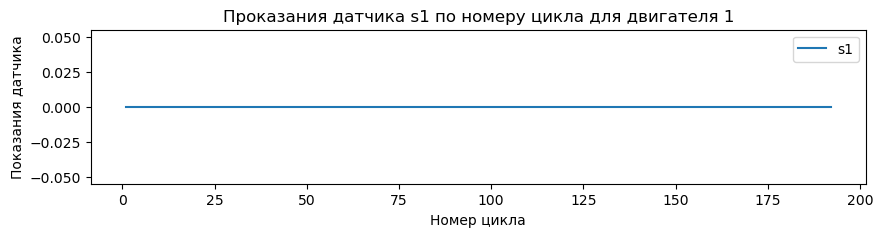

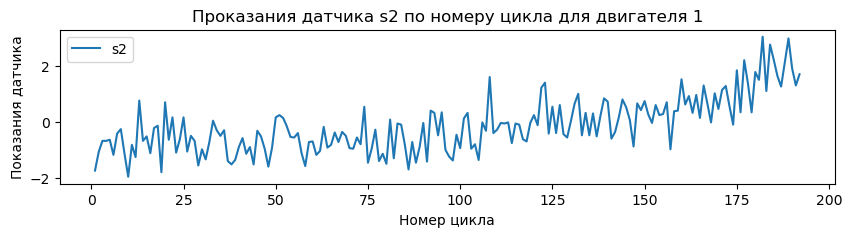

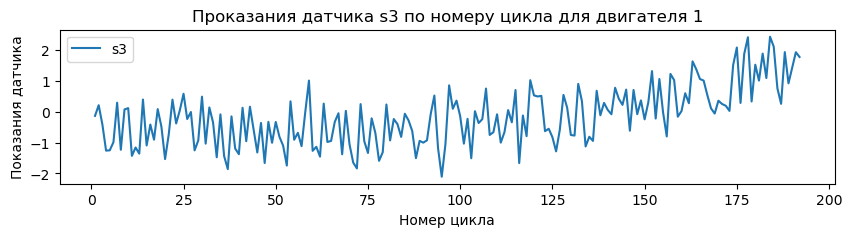

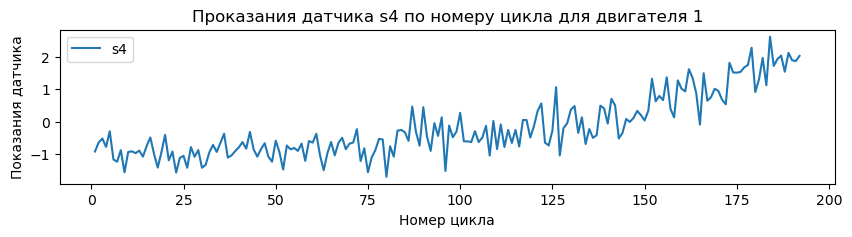

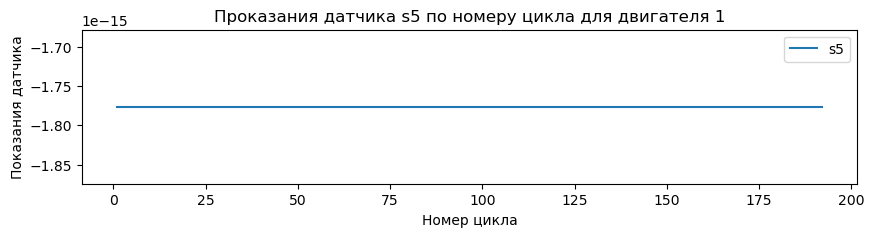

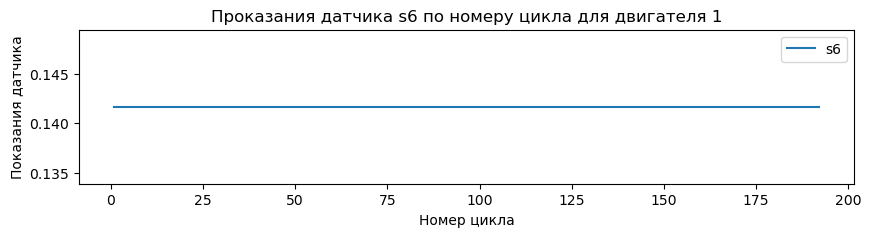

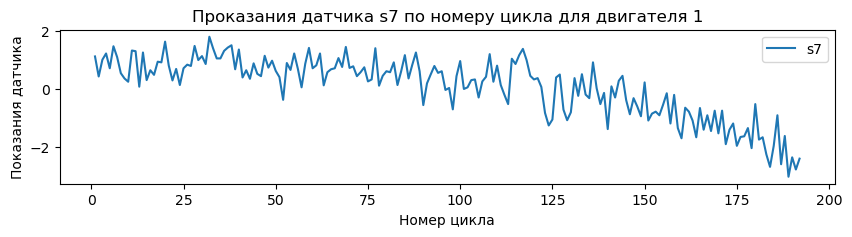

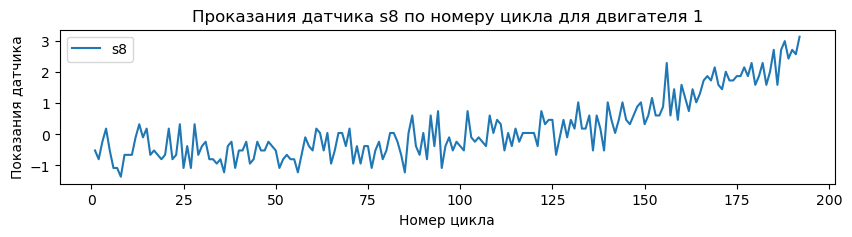

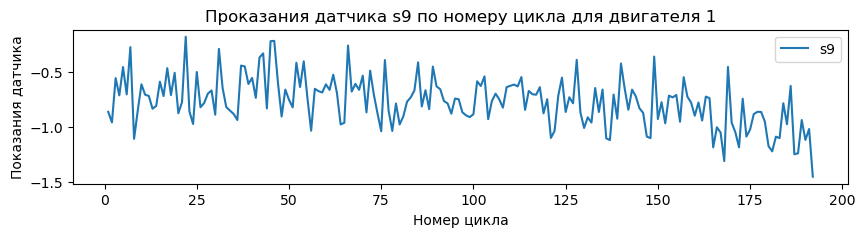

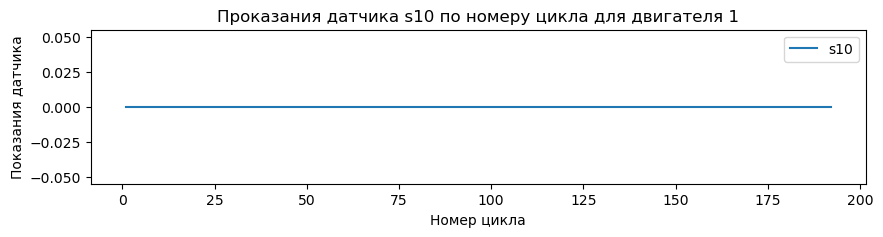

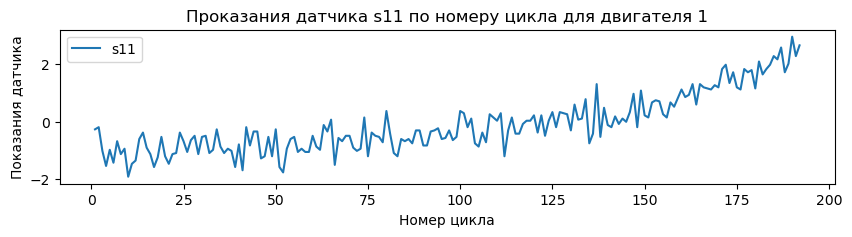

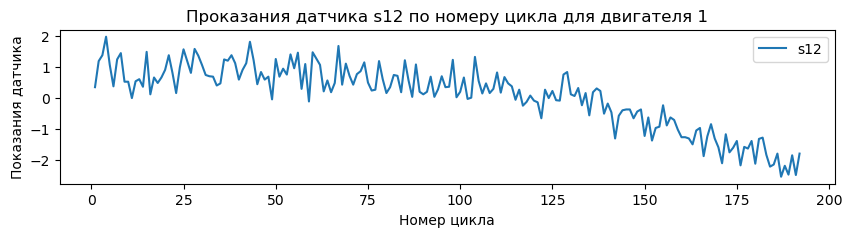

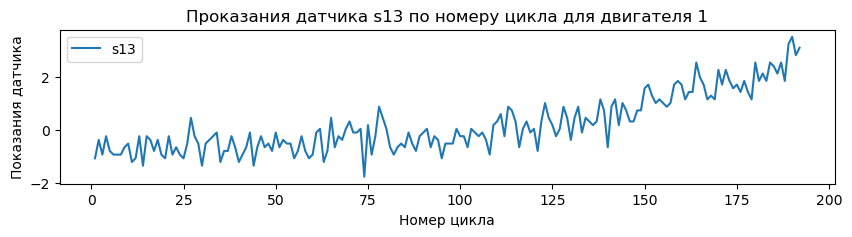

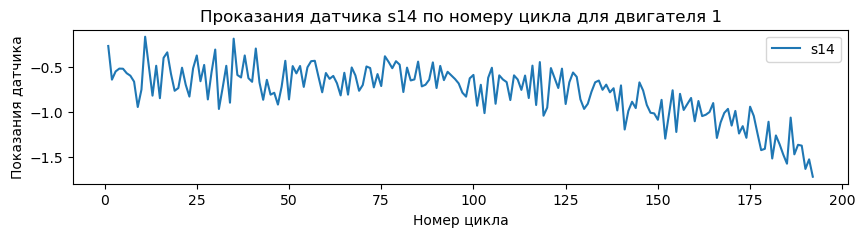

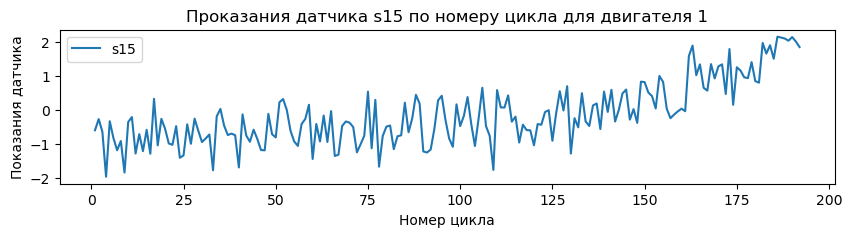

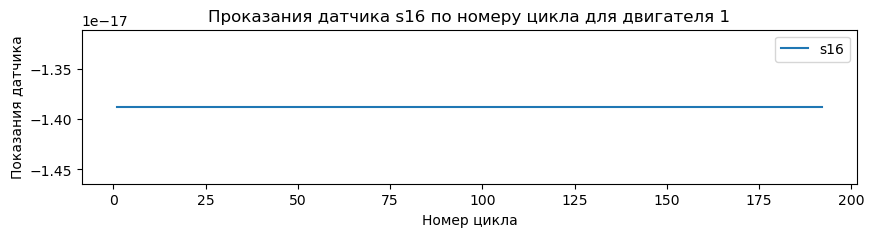

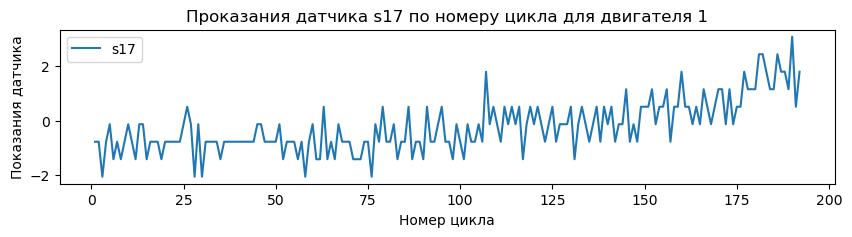

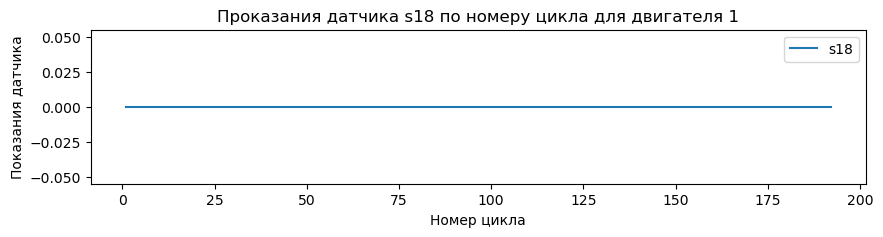

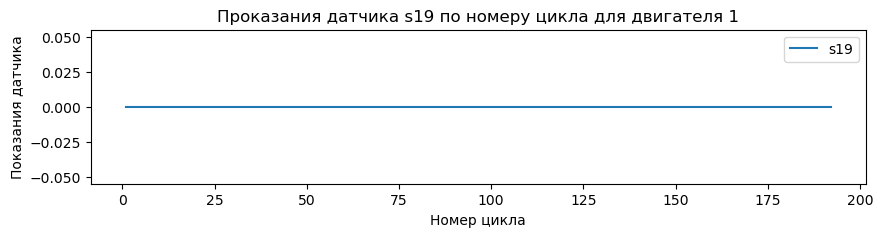

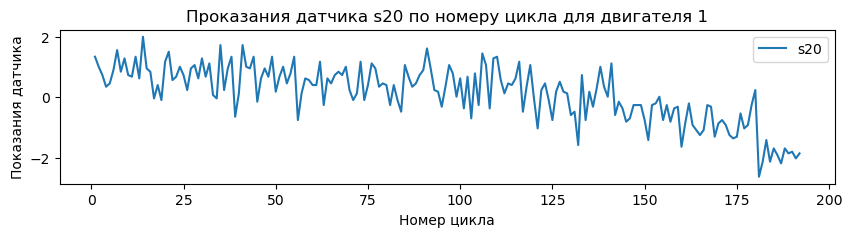

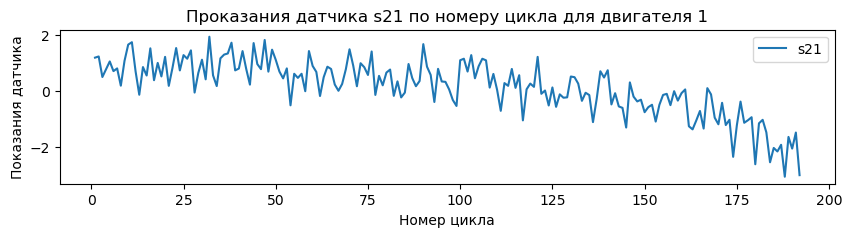

In [39]:
# Визуализируем данные датчиков по циклам работы двигателя в наборе данных

# Выбираем номер двигателя (двигатель 1)
engine_id = 1

# Применяем фильтр номера к данным
engine_data = df_train[df_train['id'] == engine_id]

# Определяем перечень сенсоров
sensors = [f's{i}' for i in range(1, 22)]

# Строим график для каждого датчика
for sensor in sensors:
    plt.figure(figsize=(10, 2))
    plt.plot(engine_data['cycle'], engine_data[sensor], label=sensor)
    plt.xlabel('Номер цикла')
    plt.ylabel('Показания датчика')
    plt.title(f'Проказания датчика {sensor} по номеру цикла для двигателя 1')
    plt.legend()
    plt.show()

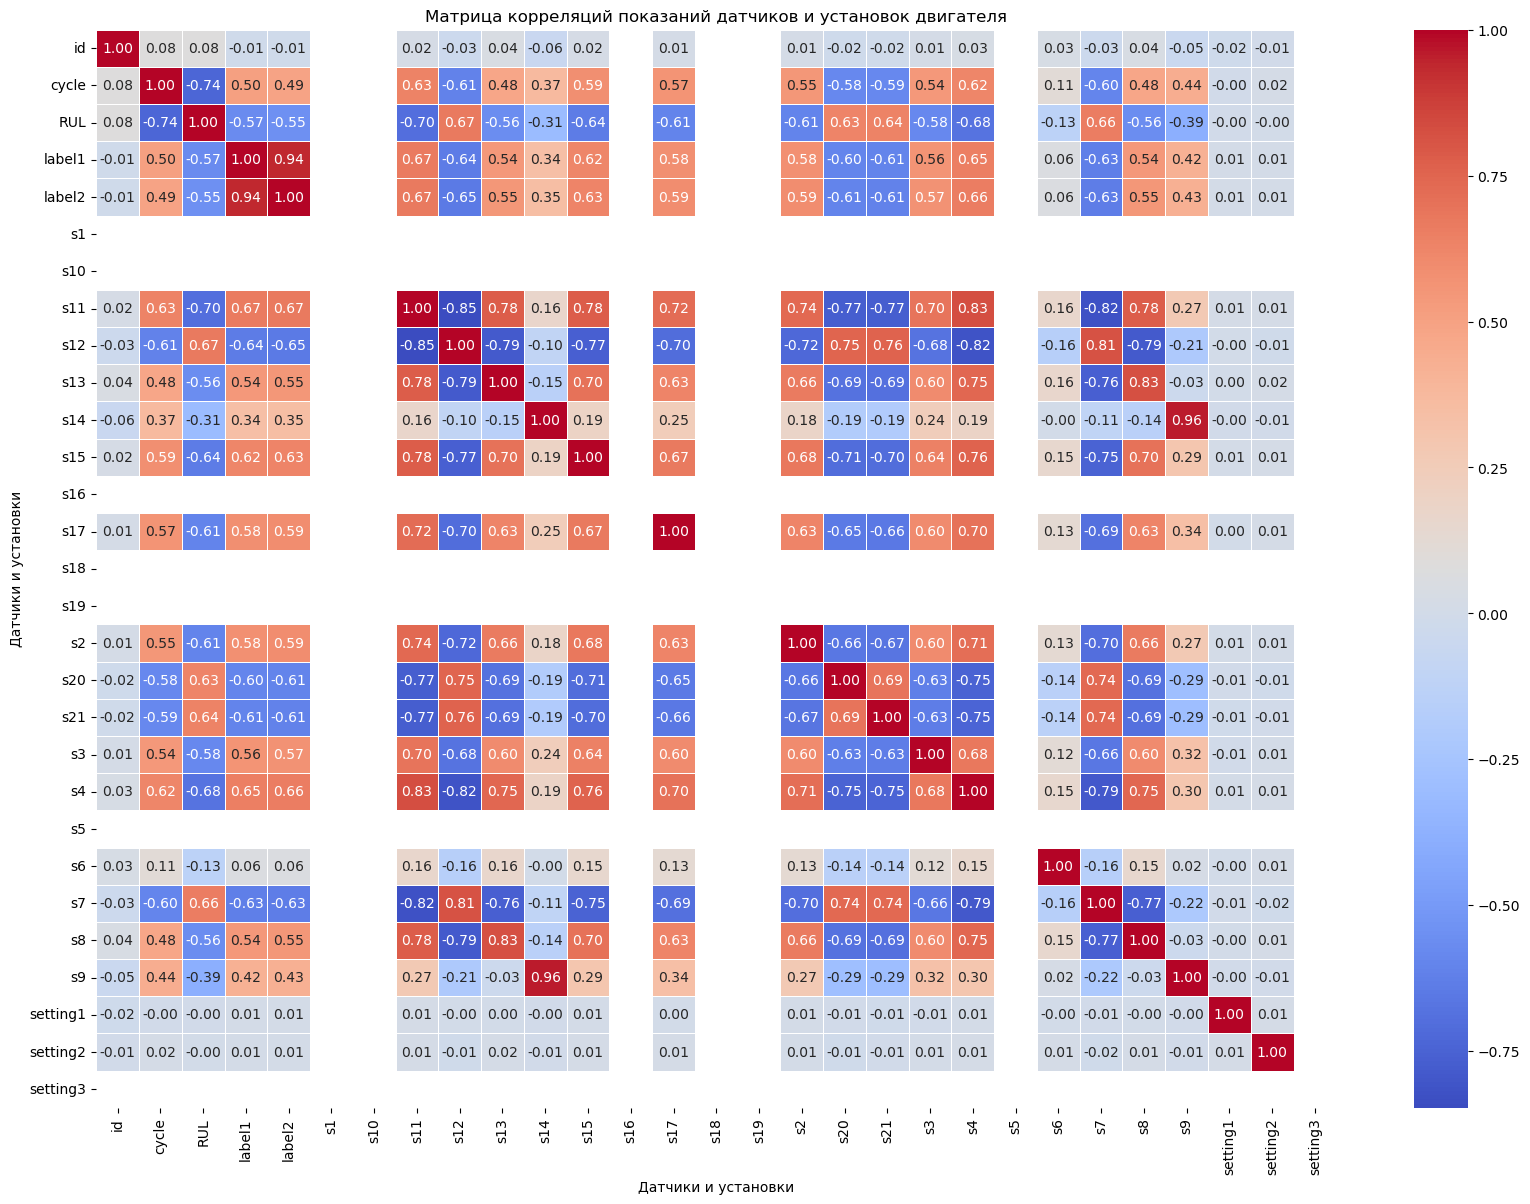

In [40]:
# Рассчитаем матрицу корреляций
correlation_matrix = df_train.corr()

# Определим визуальные параметры матрицы
plt.figure(figsize=(20, 14))

# Подготовим графическое отображение матрицы корреляций
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)

# Добавим подписи
plt.title('Матрица корреляций показаний датчиков и установок двигателя')
plt.xlabel('Датчики и установки')
plt.ylabel('Датчики и установки')

# Выводим на экран
plt.show()

In [41]:
# Сгенерируем скользящие последовательности фиксированной длины (50 циклов)
# из временных рядов, которые могут быть использованы для обучения моделей машинного обучения

sequence_length = 50

# создадим последовательности данных из временных рядов (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Здесь мы не используем "padding" (дополнение последовательностей до нужной длины), поэтому будем
         отбрасывать те последовательности, которые короче заданной длины """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [16]:
# Подготовим список столбцов для создания последовательностей данных, исключая определённые ключевые и метки,
# чтобы оставить только те столбцы, которые будут использоваться в качестве признаков

# Определим список столбцов 
sequence_cols = ['setting1', 'setting2', 'setting3']
key_cols = ['id', 'cycle']
label_cols = ['label1', 'label2', 'RUL']

input_features = df_test.columns.values.tolist()
sensor_cols = [x for x in input_features if x not in set(key_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(label_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(sequence_cols)]

# Добавляем оставшиеся столбцы, которые не были включены в ключевые или метки
# добавляя все признаки, которые могут использоваться в процессе обучения
sequence_cols.extend(sensor_cols)

print(sequence_cols)

['setting1', 'setting2', 'setting3', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7', 's8', 's9']


In [17]:
# Генерируем последовательности данных и соответствующие метки для временных рядов
seq_gen = (list(gen_sequence(df_train[df_train['id']==id], sequence_length, sequence_cols)) 
           for id in df_train['id'].unique())

# последовательности и метки преобразуем в массивы NumPy
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# Определим функцию, которая генерирует метки для последовательностей
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# Генерация меток и преобразование в массив NumPy
label_gen = [gen_labels(df_train[df_train['id']==id], sequence_length, ['label1']) 
             for id in df_train['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [18]:
# Разделим данные на обучающую и тестовую выборки, затем стандартизируем признаки

from sklearn.model_selection import train_test_split
X = df_test.drop(columns=['id', 'RUL'])
y = df_test['RUL']

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Импорт библиотеки для градиентного бустинга

from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(random_state=42)

In [42]:
# Создание и обучение модели градиентного бустинга

from sklearn.metrics import mean_squared_error, r2_score
# Вычисляем на тестовом наборе данных
y_pred = gb_model.predict(X_test_scaled)

# Оцениваем модель
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Среднеквадратическая ошибка (Mean Squared Error, MSE) : {mse}')
print(f'R^2 - коэффициент детерминации: {r2}')

Среднеквадратическая ошибка (Mean Squared Error, MSE) : 604.4956065923196
R^2 - коэффициент детерминации: 0.892953795399211


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Каждую модель из списка (Random Forest, Ada Boost, Extra Trees, Decision Tree, XGBoost)
# обучим на обучающей выборке и протестируем на тестовой выборке

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Ada Boost': AdaBoostRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

# Обучение и оценка каждой модели
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
               
    print(f'{name}:')
    print(f'  Среднеквадратическая ошибка (Mean Squared Error, MSE): {mse:.2f}')
    print(f'  Коэффициент детерминации R^2: {r2:.2f}')
    print(f'  Средняя ошибка предсказаний - Mean Absolute Error: {mae:.2f}')

Random Forest:
  Среднеквадратическая ошибка (Mean Squared Error, MSE): 548.20
  Коэффициент детерминации R^2: 0.90
  Средняя ошибка предсказаний - Mean Absolute Error: 17.86
Ada Boost:
  Среднеквадратическая ошибка (Mean Squared Error, MSE): 799.62
  Коэффициент детерминации R^2: 0.86
  Средняя ошибка предсказаний - Mean Absolute Error: 23.01
Extra Trees:
  Среднеквадратическая ошибка (Mean Squared Error, MSE): 549.61
  Коэффициент детерминации R^2: 0.90
  Средняя ошибка предсказаний - Mean Absolute Error: 17.98
Decision Tree:
  Среднеквадратическая ошибка (Mean Squared Error, MSE): 1087.73
  Коэффициент детерминации R^2: 0.81
  Средняя ошибка предсказаний - Mean Absolute Error: 23.30
XGBoost:
  Среднеквадратическая ошибка (Mean Squared Error, MSE): 621.39
  Коэффициент детерминации R^2: 0.89
  Средняя ошибка предсказаний - Mean Absolute Error: 19.17


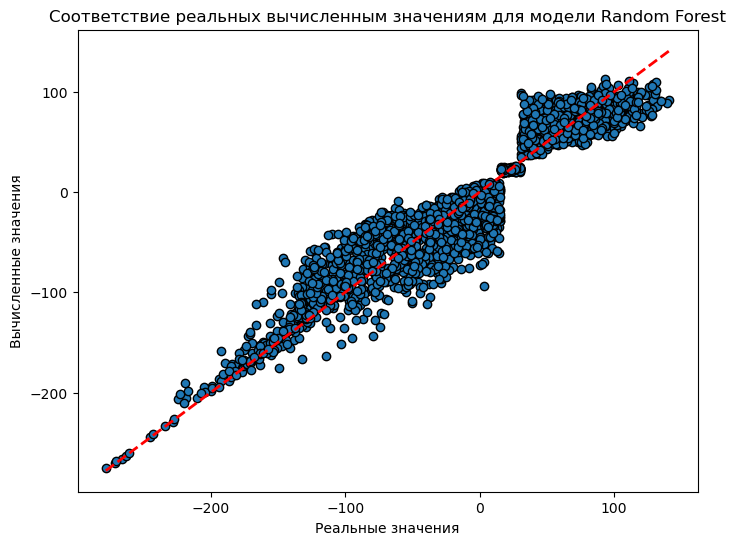

Random Forest:
  Среднеквадратическая ошибка: 548.20
  Коэффициент детерминации: 0.90
  Средняя ошибка предсказаний: 17.86


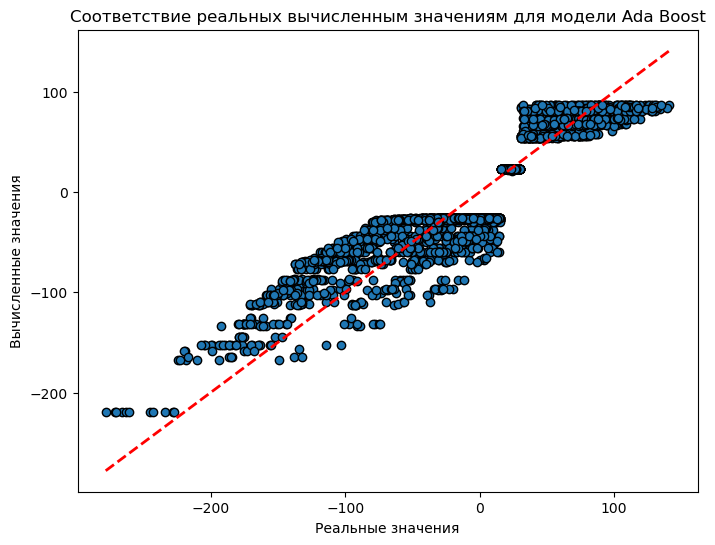

Ada Boost:
  Среднеквадратическая ошибка: 799.62
  Коэффициент детерминации: 0.86
  Средняя ошибка предсказаний: 23.01


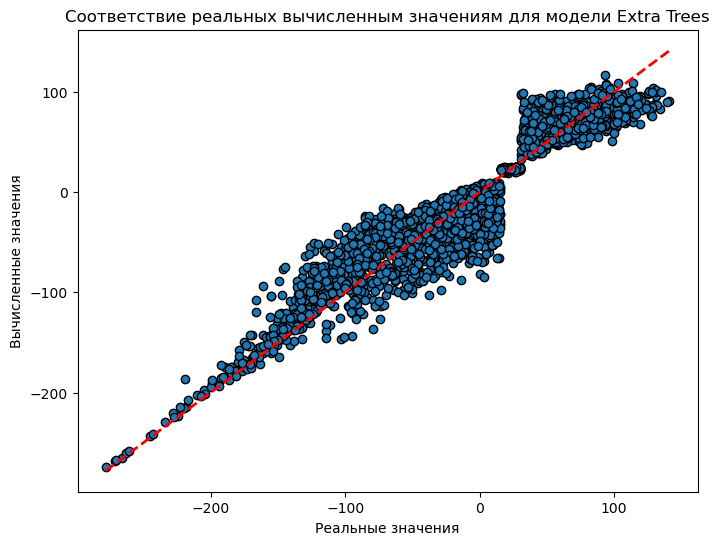

Extra Trees:
  Среднеквадратическая ошибка: 549.61
  Коэффициент детерминации: 0.90
  Средняя ошибка предсказаний: 17.98


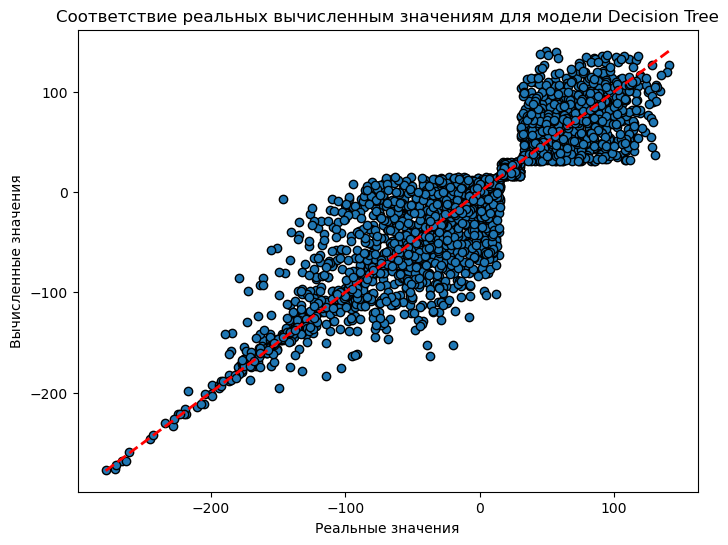

Decision Tree:
  Среднеквадратическая ошибка: 1087.73
  Коэффициент детерминации: 0.81
  Средняя ошибка предсказаний: 23.30


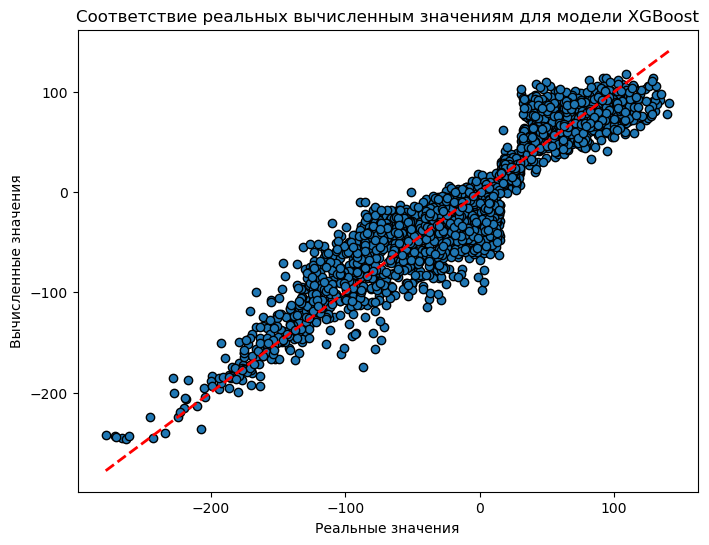

XGBoost:
  Среднеквадратическая ошибка: 621.39
  Коэффициент детерминации: 0.89
  Средняя ошибка предсказаний: 19.17


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Ada Boost': AdaBoostRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

# Обучение и оценка модели
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
        # Построение графика вычисленных против реальных значений
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
    plt.xlabel('Реальные значения')
    plt.ylabel('Вычисленные значения')
    plt.title(f'Соответствие реальных вычисленным значениям для модели {name}')
    plt.show()
    
    print(f'{name}:')
    print(f'  Среднеквадратическая ошибка: {mse:.2f}')
    print(f'  Коэффициент детерминации: {r2:.2f}')
    print(f'  Средняя ошибка предсказаний: {mae:.2f}')